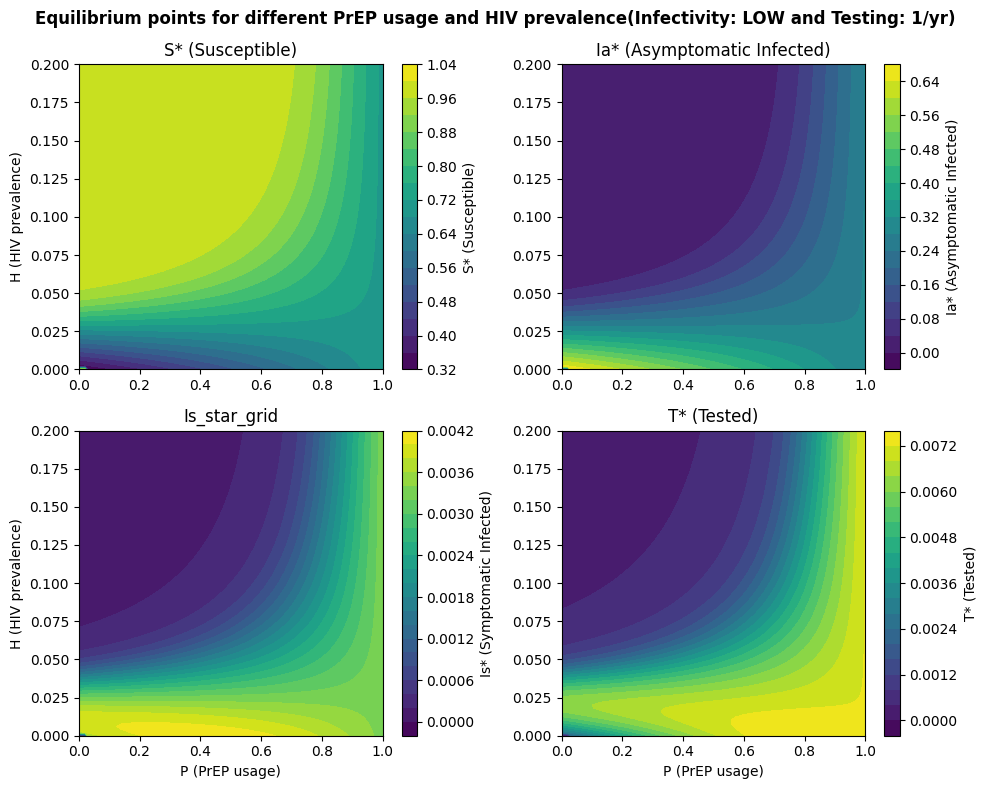

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve

# Define parameters 
beta_0_STI = 0.0016*5  # Infectivity of STIs we have two values: [high, low] = 0.0016*[7, 5]
lambda_P = 1/360 # Testing scenarios: 4/yr, 2/yr, 1/yr = 4/360, 2/360, 1/360
gamma = 1/1.32/360
tilde_gamma = 1/7
mu = 1.0/45/360
psi = 0.85
lambda_0 = 1/14
Sigma = 0.01/365
#lambda_H = 0.4
C = 50
beta_0_HIV = 0.6341/360

# Define the range for H and P
H_values = np.linspace(0, 0.2, 100)
P_values = np.linspace(0, 1, 100)

# Create storage for results
S_star_grid = np.zeros((100, 100))
Ia_star_grid = np.zeros((100, 100))
Is_star_grid = np.zeros((100, 100))

# Compute equilibrium points for each (H, P) pair
for i, H in enumerate(H_values):
    for j, P in enumerate(P_values):

        # Define auxiliary functions
        def m(H):
            m_min = 0.0
            m_max = 1
            H_thresh = 0.2
            return m_min + (m_max - m_min) * (1 - np.exp(-H / H_thresh))
        
        def Lambda(Ia, Is, H, P):
            return beta_0_STI * (1 - m(H) * (1 - P)) * (Ia + Is)
        
        def lambda_a(P, H):
            return lambda_H(H) * (1 - P) + lambda_P * P
        
        def lambda_s(P, H):
            return lambda_0 + lambda_a(P, H)
        
        def lambda_H(H):
            return C*beta_0_HIV*(1-m(H))*H
        
        # Recalculate lambda_a and lambda_s for current H and P
        def equations(vars):
            S, Ia, Is = vars
            
            eq1 = -Lambda(Ia, Is, H, P) * S + gamma * Ia + tilde_gamma * (1 - (S + Ia + Is)) + mu - mu * S - Sigma
            eq2 = psi * Lambda(Ia, Is, H, P) * S - (gamma + lambda_a(P, H) + mu) * Ia + psi * Sigma
            eq3 = (1 - psi) * Lambda(Ia, Is, H, P) * S - (lambda_s(P, H) + mu) * Is + (1 - psi) * Sigma

            return [eq1, eq2, eq3]

        # Solve the system for current (H, P)
        solution = fsolve(equations, [0.5, 0.1, 0.1])
        S_star_grid[i, j], Ia_star_grid[i, j], Is_star_grid[i, j] = solution

# Plot results for visualization
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot S_star_grid
axs[0, 0].contourf(P_values, H_values, S_star_grid, levels=20, cmap="viridis")
axs[0, 0].set_title('S* (Susceptible)')
axs[0, 0].set_ylabel("H (HIV prevalence)")
fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0], label="S* (Susceptible)")

# Plot Ia_star_grid
axs[0, 1].contourf(P_values, H_values, Ia_star_grid, levels=20, cmap="viridis")
axs[0, 1].set_title('Ia* (Asymptomatic Infected)')
fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1], label="Ia* (Asymptomatic Infected)")

# Plot Is_star_grid
axs[1, 0].contourf(P_values, H_values, Is_star_grid, levels=20, cmap="viridis")
axs[1, 0].set_title('Is_star_grid')
axs[1, 0].set_ylabel("H (HIV prevalence)")
axs[1, 0].set_xlabel("P (PrEP usage)")
fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0], label="Is* (Symptomatic Infected)")

# Plot 1-(S+Ia+Is)
axs[1, 1].contourf(P_values, H_values, (1 - (S_star_grid + Ia_star_grid + Is_star_grid)), levels=20, cmap="viridis")
axs[1, 1].set_title('T* (Tested)')
axs[1, 1].set_xlabel("P (PrEP usage)")
fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1], label="T* (Tested)")
fig.suptitle("Equilibrium points for different PrEP usage and HIV prevalence(Infectivity: LOW and Testing: 1/yr)", fontweight="bold")
plt.tight_layout()
plt.show()